# AAPL stock movements

The purpose is to create a model that will predict up and down movements of one of the OHLC(Open,High,Low,Close) metrics - Close price. It displays the price of the stock at the end of the trading day. All the data will be drawn from Yahoo Finance.
We'll use the following approach:
- We'll create a model based on regression and we'll try to predict the Close value for the subsequent days. Note that we're not trying to predict the movements but the exact value of the target variable. Only after we already have the predictions we can transform them into up-down movements
- We'll also use Exponential smoothing to reduce the complexity of the model and allow it not to overfit all the up and down movements.

## Regression approach

This variant seems prospective because we'll be able to use Long short-term memory(LSTM) recurrent neural networks, which have a quite good performance when it comes to time series with no definite periods

#### Importing the neccessary libraries

In [20]:
import numpy as np
import pandas as pd
from pandas import DataFrame as D
from pandas import Series as S
import matplotlib.pyplot as plt
from pandas_datareader import data as d #Will be used to read the data from yahoo finance
from datetime import date

#### Reading and visualizing the data

Start date here is 2017 because even well-optimized model can't catch the concept of the movements in the long period of time, because the stock prices now daily change far more drastically than 10 years ago forinstance

In [21]:
data = d.DataReader("AAPL", 
                    start='2017-01-01',
                    end=date.today(),
                    data_source='yahoo')
comparing_data = d.DataReader("AAPL", 
                            start='2000-04-30',
                            end=date.today(),
                            data_source='yahoo')

In [22]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,29.082500,28.690001,28.950001,29.037500,115127600.0,27.459938
2017-01-04,29.127501,28.937500,28.962500,29.004999,84472400.0,27.429203
2017-01-05,29.215000,28.952499,28.980000,29.152500,88774400.0,27.568691
2017-01-06,29.540001,29.117500,29.195000,29.477501,127007600.0,27.876030
2017-01-09,29.857500,29.485001,29.487499,29.747499,134247600.0,28.131361


Text(0.5, 1.0, 'Close Prices 2000-2021')

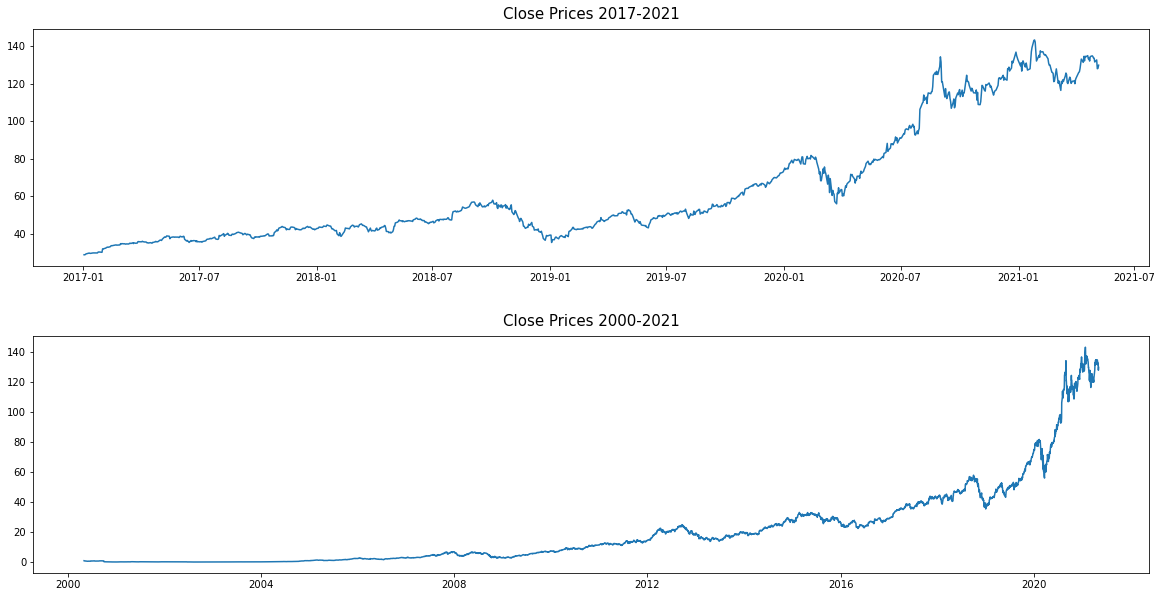

In [23]:
figure, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,10))
plt.subplots_adjust(hspace=0.3)
axes[0].plot(data.Close)
axes[0].set_title('Close Prices 2017-2021',fontsize=15,pad=10)
axes[1].plot(comparing_data.Close)
axes[1].set_title('Close Prices 2000-2021',fontsize=15,pad=10)

#### Normalization

We'll use a technique which normalizes the data gradually by distinct intervals. The purpose is to set higher values to early stages of our data and retain their importance. 

But first we need to split the time series into train and test sets

In [24]:
from sklearn.model_selection import train_test_split
test_size = 0.1
train_data,test_data = train_test_split(data.Close.values,random_state=42,test_size = test_size,shuffle=False)

In [25]:
#Function which normalizes the time series gradually
def grad_norm(train_data,test_data):
    global shape
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(copy=False)
    shape = train_data.shape[0]
    train_data = train_data.reshape(-1,1)
    step = int(round(shape/5,-1)) #The step of gradual normalization
    for i in range(0,4*step,step):
        scaler.fit(train_data[i:i+step])
        train_data[i:i+step] = scaler.transform(train_data[i:i+step])
    scaler.fit(train_data[i+step:])
    #We train and transform the remaining train_data
    train_data[i+step:] = scaler.transform(train_data[i+step:])
    #After that we just transform test_data without training on it so it could remain unseen
    test_data = scaler.transform(test_data.reshape(-1,1)) 
grad_norm(train_data,test_data)

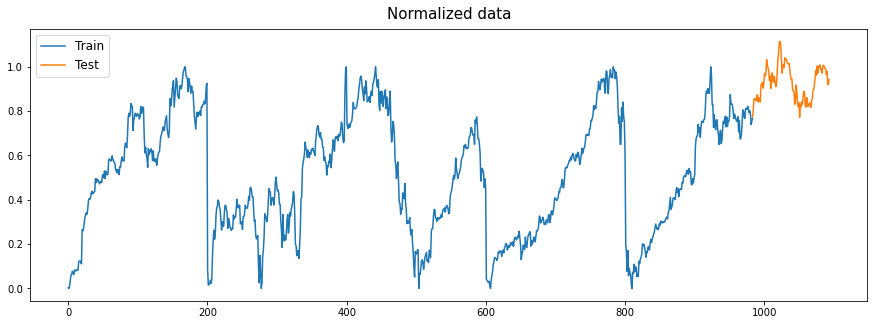

In [26]:
# Time series visualization function
def train_test_plot(train_data,test_data,title):
    train_shape = train_data.shape[0]
    test_shape = test_data.shape[0]
    plt.figure(figsize=(15,5))
    plt.plot(np.linspace(0,train_shape,train_shape),train_data,label='Train')
    plt.plot(np.linspace(train_shape,train_shape + test_shape,test_shape),test_data,label='Test')
    plt.title(title,fontsize=15,pad=10)
    plt.legend(fontsize=12)
train_test_plot(train_data,test_data,'Normalized data')

#### Exponential Smoothing

This is a technique which can be used to reduce the complexity of the data and make it more predictable especially in the case of time series

In [27]:
#Function which performs the exponential smoothing
def exp_smoothing(data,smoothing_factor=0.5):
    base = 0
    for i in range(data.shape[0]):
        base = smoothing_factor*data[i] + (1 - smoothing_factor)*base
        data[i] = base
exp_smoothing(train_data, 0.5)
# There is no need in smoothing the test data, because it won't help in training

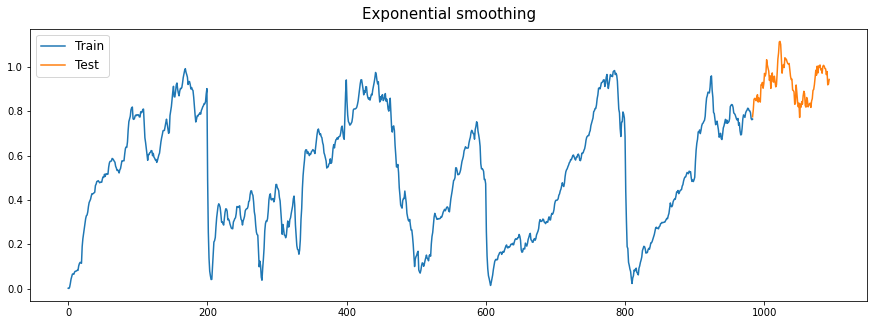

In [28]:
train_test_plot(train_data,test_data, 'Exponential smoothing')

#### Reconfiguration of Close price data

The common approach here is to predict every next value of time series by the certain number of its predecessors

In [29]:
# Function for data reconfiguration
# period is the number of preditctors or the number of predecessors we use to predict every next value in the time series 
def change_data(data, period =30): 
    predictors = []
    target = []
    for i in range(len(data) - period):
        x = data[i:i+period] # lag here is 1
        y = data[i+period]
        predictors.append(x)
        target.append(y)
    predictors = np.array(predictors).reshape(data.shape[0] - period,1,period,1)
    target = np.array(target)
    return predictors, target, period

In [30]:
all_data = np.concatenate([train_data,test_data])
X, y, period= change_data(all_data)
X[0] #First row of our new data

array([[[0.00135337],
        [0.00067669],
        [0.00648038],
        [0.02291546],
        [0.04237592],
        [0.05335539],
        [0.06550762],
        [0.06637866],
        [0.06462805],
        [0.07374649],
        [0.07820159],
        [0.07824302],
        [0.08055398],
        [0.08254229],
        [0.08239132],
        [0.1021992 ],
        [0.1127278 ],
        [0.11809615],
        [0.11744907],
        [0.1142107 ],
        [0.18962671],
        [0.22504446],
        [0.24847896],
        [0.27279241],
        [0.29785779],
        [0.31569961],
        [0.32857643],
        [0.33189176],
        [0.34572929],
        [0.37065774]]])

#### Train-Test-Val seperation

In [31]:
new_test_size = test_size * (X.shape[0] + period)/ X.shape[0] # With this we can get the same test set
X_train, X_not_train, y_train, y_not_train = train_test_split(X, y, random_state=42, test_size = new_test_size, shuffle = False)
X_val, X_test, y_val, y_test = train_test_split(X_not_train, y_not_train, random_state=42, test_size = 0.7, shuffle = False)

#### Training a CNN LSTM model

In [32]:
#Libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
import tensorflow as tf

In [33]:
# Structure of the model
def make_model():
    tf.random.set_seed(42)
    np.random.seed(42)
    model = Sequential()
    #Timedistributed layer is usually used on RNN, including LSTM, to keep one-to-one relations on input and output
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), 
                                     input_shape=(None, period, 1))) 
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    
    model.add(TimeDistributed(Flatten()))
    #LSTM is a recurrent neural network specialized in handling time series
    #Dropout allows not to overfit the train data and generalize much better
    model.add(LSTM(units = 200, return_sequences = True, 
                   activation = 'relu',dropout = 0.2))
    model.add(LSTM(units = 200, return_sequences = True, 
                   activation = 'relu',dropout = 0.2))
    model.add(LSTM(units = 200, return_sequences = False,
                   activation = 'relu',dropout = 0.2))
    model.add(Dense(units = 1, activation = 'linear'))
    return model
model = make_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, None, 30, 64)      128       
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 15, 64)      0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 960)         0         
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 200)         928800    
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 200)         320800    
_________________________________________________________________
lstm_8 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [34]:
model = make_model()
tf.random.set_seed(12345)
np.random.seed(12345)
model.compile(optimizer='adam', loss='mae')
history = model.fit(X_train, y_train, 
                    epochs = 300, validation_data=(X_val,y_val), verbose=1)

Epoch 1/300
30/30 [==============================] - 11s 70ms/step - loss: 0.4013 - val_loss: 0.0839
Epoch 2/300
30/30 [==============================] - 1s 31ms/step - loss: 0.1269 - val_loss: 0.0379
Epoch 3/300
30/30 [==============================] - 1s 31ms/step - loss: 0.1012 - val_loss: 0.0624
Epoch 4/300
30/30 [==============================] - 1s 31ms/step - loss: 0.0831 - val_loss: 0.0525
Epoch 5/300
30/30 [==============================] - 1s 32ms/step - loss: 0.0694 - val_loss: 0.0525
Epoch 6/300
30/30 [==============================] - 1s 31ms/step - loss: 0.0649 - val_loss: 0.0325
Epoch 7/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0575 - val_loss: 0.0519
Epoch 8/300
30/30 [==============================] - 1s 31ms/step - loss: 0.0623 - val_loss: 0.0693
Epoch 9/300
30/30 [==============================] - 1s 31ms/step - loss: 0.0534 - val_loss: 0.0263
Epoch 10/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0563 - val_loss: 0.052

30/30 [==============================] - 1s 30ms/step - loss: 0.0379 - val_loss: 0.0233
Epoch 83/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0351 - val_loss: 0.0425
Epoch 84/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0327 - val_loss: 0.0608
Epoch 85/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0332 - val_loss: 0.0401
Epoch 86/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0341 - val_loss: 0.0344
Epoch 87/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0342 - val_loss: 0.0257
Epoch 88/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0363 - val_loss: 0.0310
Epoch 89/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0331 - val_loss: 0.0233
Epoch 90/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0333 - val_loss: 0.0332
Epoch 91/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0332 - val_loss: 0.0344
Epo

30/30 [==============================] - 1s 31ms/step - loss: 0.0286 - val_loss: 0.0283
Epoch 163/300
30/30 [==============================] - 1s 31ms/step - loss: 0.0331 - val_loss: 0.0324
Epoch 164/300
30/30 [==============================] - 1s 31ms/step - loss: 0.0331 - val_loss: 0.0306
Epoch 165/300
30/30 [==============================] - 1s 31ms/step - loss: 0.0319 - val_loss: 0.0238
Epoch 166/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0290 - val_loss: 0.0277
Epoch 167/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0268 - val_loss: 0.0227
Epoch 168/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0287 - val_loss: 0.0297
Epoch 169/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0293 - val_loss: 0.0272
Epoch 170/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0297 - val_loss: 0.0292
Epoch 171/300
30/30 [==============================] - 1s 31ms/step - loss: 0.0322 - val_loss: 0

30/30 [==============================] - 1s 31ms/step - loss: 0.0283 - val_loss: 0.0241
Epoch 243/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0284 - val_loss: 0.0263
Epoch 244/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0291 - val_loss: 0.0240
Epoch 245/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0265 - val_loss: 0.0335
Epoch 246/300
30/30 [==============================] - 1s 31ms/step - loss: 0.0270 - val_loss: 0.0241
Epoch 247/300
30/30 [==============================] - 1s 32ms/step - loss: 0.0300 - val_loss: 0.0260
Epoch 248/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0278 - val_loss: 0.0361
Epoch 249/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0294 - val_loss: 0.0413
Epoch 250/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0285 - val_loss: 0.0279
Epoch 251/300
30/30 [==============================] - 1s 30ms/step - loss: 0.0286 - val_loss: 0

#### Visualization and evaluation of predictions

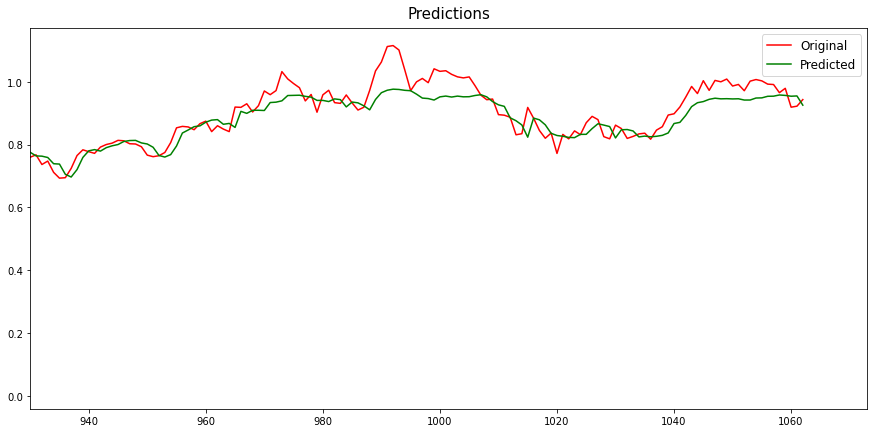

In [35]:
#Function which allows to compare initial and predicted data
def prediction_plot(model, X, y, title = 'Predictions'):
    plt.figure(figsize = (15,7))
    plt.plot(y, c='r', label = 'Original')
    plt.plot(model.predict(X), c='g', label='Predicted')
    plt.title(title,fontsize = 15,pad = 10)
    plt.legend(fontsize=12)
    plt.xlim(y_train.shape[0]+y_test.shape[0]-100,y.shape[0]+10) 
prediction_plot(model, X, y)

In [36]:
#This transforms predicted values into two classes, which represent up and down movements of Close price
def up_down(x):
    x = S(x.reshape(-1))
    up_down_values=np.where((x.shift(-1) - x) > 0,1,0)
    return up_down_values
#Shows all the necessary statistics to evaluate the model 
def evaluation(model, X_test, y_test):
    from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix
    test_shape = y_test.shape[0]
    labels = up_down(data['Close'].values)[period:]
    f1 = f1_score(labels[-test_shape:], up_down(model.predict(X_test)))
    recall_neg = recall_score(labels[-test_shape:], up_down(model.predict(X_test)), pos_label = 0)
    recall_pos = recall_score(labels[-test_shape:], up_down(model.predict(X_test)), pos_label = 1)
    accuracy = accuracy_score(labels[-test_shape:], up_down(model.predict(X_test)))
    confusion = confusion_matrix(labels[-test_shape:], up_down(model.predict(X_test)))
    print('F1 score:  ', f1)
    print('-----------------------------------------')
    print('Negative Recall Score:  ', recall_neg)
    print('-----------------------------------------')
    print('Positive Recall SCore :  ', recall_pos)
    print('-----------------------------------------')
    print('Accuracy SCore:  ', accuracy)
    print('-----------------------------------------')
    print('Confusion Matrix  ')
    print('    {0}'.format(confusion[0]))
    print('    {0}'.format(confusion[1]))

In [37]:
evaluation(model, X_test, y_test)

F1 score:   0.5974025974025974
-----------------------------------------
Negative Recall Score:   0.6052631578947368
-----------------------------------------
Positive Recall SCore :   0.5897435897435898
-----------------------------------------
Accuracy SCore:   0.5974025974025974
-----------------------------------------
Confusion Matrix  
    [23 15]
    [16 23]


#### Predictions

In [38]:
def next_day_prediction():
    #Here we simply append the last prediction to the array of predictors
    new_row = np.append(X_test[-1].reshape(-1),model.predict(X_test[-1].reshape(1,1,period,1))[0,0])[1:] 
    #Now with new_row we can predict the vales of Close price for the next day
    next_day_value = model.predict(new_row.reshape(1,1,period,1))
    #We subtract today's close price from the predicted price to define the movement
    next_day_movement = np.sign(next_day_value - test_data[-1])[0]
    if next_day_movement == 1:
        print('----------------------------------------------------------')
        print()
        print('   Close price prediction for the next day is Up')
        print()
        print('----------------------------------------------------------')
    else:
        print('----------------------------------------------------------')
        print()
        print('   Close price prediction for the next day is Down')
        print()
        print('----------------------------------------------------------')
next_day_prediction() 

----------------------------------------------------------

   Close price prediction for the next day is Down

----------------------------------------------------------


We could also create several other models with lags more than 1. That would allow us to make predictions for more than one day into the future, but I don't think it could give any valuable information. Even with lag = 1 we barely reach 60% accuracy so the other models won't have better performance

I also tried to predict movements by classification adding some other features from TA-Lib while retaining the first approach of training by periods. The problem is the accuaracy and other metrics had had roughly 50% magnitude, which is equivalent to the accuracy of coin_flipping. So I decided not to include that variant here.